In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/Users/gimli/projects/igre


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from src.models.ig import information_gain as ig
import scipy.signal as sig

In [3]:
def cvtData(line):
    data = line.strip().split(" ")
    while '' in data:
        data.remove('')
    return data

with open("/Users/gimli/Qsync/datasets/Gent-Altairpiece/lamb/LamGods_Adoration_Lamb.ims", "r") as imsfile:
    line = imsfile.readline()
    version = cvtData(line)[0]
    
    line = imsfile.readline()
    [width, height, depth] = cvtData(line)
    
    print("expected dimensions:", width, height, depth)
    
    matrix = np.zeros((int(width), int(height), int(depth)))

    all_data = []
    line = imsfile.readline()
    while line:
        all_data.extend(cvtData(line))
        try:
            line = imsfile.readline()
        except Exception as e:
            print(len(all_data))

expected dimensions: 134 126 227
3832386


In [4]:
imgs = np.asarray(all_data[:3815784]).reshape(226, 126,134)

In [5]:
# This legend is from Steven's excel

legend = [["scaling", "Hydrocerussite", "2PbCO3.Pb(OH)2", "775,63"],
["weightf", "Hydrocerussite", "2PbCO3.Pb(OH)2", "775,63"],
["scaling", "Cerussite", "PbCO3", "267,21"],
["weightf", "Cerussite", "PbCO3", "267,21"],
["scaling", "Lead tin yellow", "Pb2SnO4", "597,11"],
["weightf", "Lead tin yellow", "Pb2SnO4", "597,11"],
["scaling", "Cinnabar", "HgS", "232,67"],
["weightf", "Cinnabar", "HgS", "232,67"],
["scaling", "Calcite", "CaCO3", "100,09"],
["weightf", "Calcite", "CaCO3", "100,09"],
["scaling", "Posnjakite", "Cu4(SO4)(OH)6 · H2O", "470,31"],
["weightf", "Posnjakite", "Cu4(SO4)(OH)6 · H2O", "470,31"],
["scaling", "Gold", "Au", "196,97"],
["weightf", "Gold", "Au", "196,97"],
["scaling", "Zincite", "ZnO", "81,38"],
["weightf", "Zincite", "ZnO", "81,38"],
["scaling", "Goethite", "FeO(OH)", "88,85"],
["weightf", "Goethite", "FeO(OH)", "88,85"]]

In [6]:
# This bands were selected by Steven as relevant for the Lamb
lamb = imgs[[1, 2, 22, 23, 45, 46, 67, 68, 89, 90, 111, 112, 133, 134, 155, 156, 177, 178],:,:].astype(float);

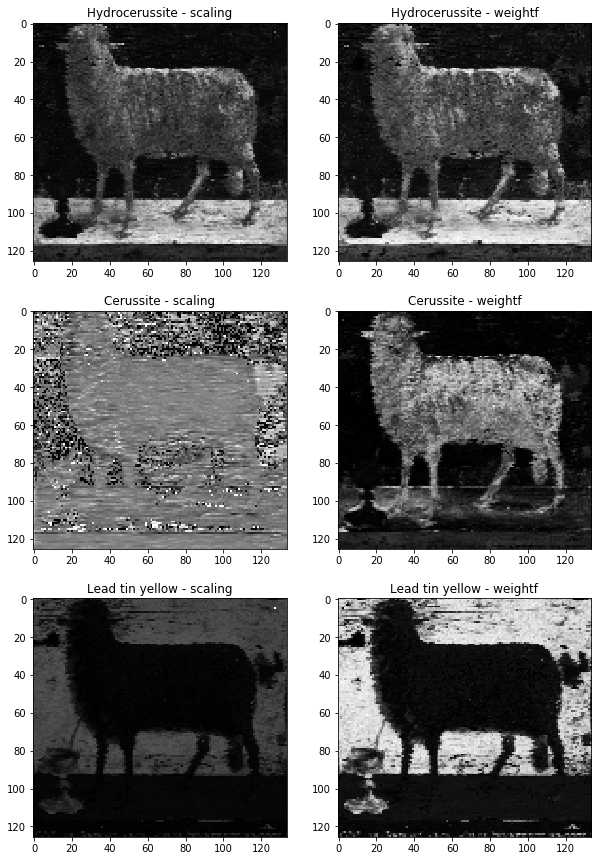

In [7]:
plt.figure(figsize=(10,15))
for i in np.arange(6):
    ax = plt.subplot(3,2,i+1)
    ax.imshow(np.flip(lamb[i,:,:],0), cmap='gray')
    ax.set_title(f"{legend[i][1]} - {legend[i][0]}")
plt.show()

In [8]:
# Creation of hypercube
xrpd = cv2.flip(lamb, flipCode=1)
xrpd = np.moveaxis(xrpd, 0, 2)

In [20]:
## Load registered data from Michal
xrf_folder='/Users/gimli/Qsync/datasets/Gent-Altairpiece/lamb/registered-downsample'
files = os.listdir(xrf_folder)
xrf = np.zeros((xrpd.shape[0], xrpd.shape[1], len(files)))
for idx, file in enumerate(sorted(files)):
    xrf[:,:, idx] = cv2.cvtColor(cv2.imread(os.path.join(xrf_folder, file)),cv2.COLOR_BGR2GRAY)/255.0

In [21]:
# N(0,1) NORMALIZATION PRIMITIVES

In [22]:
pd_avg = np.mean(xrpd.reshape((xrpd.shape[0] * xrpd.shape[1], xrpd.shape[2])), axis=0)
pd_std = np.std(xrpd.reshape((xrpd.shape[0] * xrpd.shape[1], xrpd.shape[2])), axis=0)
f_avg = np.mean(xrf.reshape((xrf.shape[0] * xrf.shape[1], xrf.shape[2])), axis=0)
f_std = np.std(xrf.reshape((xrf.shape[0] * xrf.shape[1], xrf.shape[2])), axis=0)

In [ ]:
# MIN - MAX NORMALIZATION

In [82]:
pd_avg = np.min(xrpd.reshape((xrpd.shape[0] * xrpd.shape[1], xrpd.shape[2])), axis=0)
pd_std = np.max(np.abs(xrpd.reshape((xrpd.shape[0] * xrpd.shape[1], xrpd.shape[2]))), axis=0) - pd_avg
f_avg = np.min(xrf.reshape((xrf.shape[0] * xrf.shape[1], xrf.shape[2])), axis=0)
f_std = np.max(np.abs(xrf.reshape((xrf.shape[0] * xrf.shape[1], xrf.shape[2]))), axis=0) - f_avg

In [83]:
# XRPD data normalization

In [84]:
pd_norm = np.zeros(xrpd.shape)
for dim in range(pd_avg.shape[0]):
    pd_norm[:,:,dim] = (xrpd[:,:,dim] - pd_avg[dim]) / pd_std[dim]

In [85]:
# XRF data normalization

In [86]:
f_norm = np.zeros(xrf.shape)
for dim in range(f_avg.shape[0]):
    f_norm[:,:,dim] = (xrf[:,:,dim] - f_avg[dim]) / f_std[dim]

Training of transformation function:

f: **\[CuK, PbM, SnL\]** (XRF) -> **\[HydroCerrusite, Cerrusite, LeadTinYellow\]** bands in XRPD

In [87]:
for idx, file in enumerate(sorted(files)):
    print(f"{idx} - {file}")

0 - ArK.png
1 - AsK.png
2 - AuL.png
3 - AuM.png
4 - BaL.png
5 - BiL.png
6 - CaK.png
7 - ClK.png
8 - CoK.png
9 - Continuum.png
10 - CrK.png
11 - CuK.png
12 - FeK.png
13 - HgL.png
14 - HgM.png
15 - KK.png
16 - MnK.png
17 - NiK.png
18 - PbL.png
19 - PbM.png
20 - RhK.png
21 - RhL.png
22 - SK.png
23 - SnK.png
24 - SnL.png
25 - SrK.png
26 - TiK.png
27 - ZnK.png
28 - chisq.png


In [101]:
[gain, approx, net] = ig(f_norm[:115,:,[11,19,24]], pd_norm[:115,:,[1,3,5]])

Selecting 25000 samples randomly for use by algorithm.
Adding input layer, width = 3
Adding dense layer, width = 25
Adding dense layer, width = 25
Adding dense layer, width = 3
Compiling model took 0.1973's.
Train on 12328 samples, validate on 3082 samples
Epoch 1/300
12328/12328 [==============================] - 1s 92us/sample - loss: 0.0541 - mean_squared_error: 0.0541 - val_loss: 0.0289 - val_mean_squared_error: 0.0289
Epoch 2/300
12328/12328 [==============================] - 1s 63us/sample - loss: 0.0259 - mean_squared_error: 0.0259 - val_loss: 0.0254 - val_mean_squared_error: 0.0254
Epoch 3/300
12328/12328 [==============================] - 1s 72us/sample - loss: 0.0246 - mean_squared_error: 0.0246 - val_loss: 0.0241 - val_mean_squared_error: 0.0241
Epoch 4/300
12328/12328 [==============================] - 1s 64us/sample - loss: 0.0239 - mean_squared_error: 0.0239 - val_loss: 0.0234 - val_mean_squared_error: 0.0234
Epoch 5/300
12328/12328 [==============================] - 1s 6

12328/12328 [==============================] - 1s 71us/sample - loss: 0.0215 - mean_squared_error: 0.0215 - val_loss: 0.0216 - val_mean_squared_error: 0.0216
Epoch 48/300
12328/12328 [==============================] - 1s 81us/sample - loss: 0.0215 - mean_squared_error: 0.0215 - val_loss: 0.0213 - val_mean_squared_error: 0.0213
Epoch 49/300
12328/12328 [==============================] - 1s 60us/sample - loss: 0.0215 - mean_squared_error: 0.0215 - val_loss: 0.0214 - val_mean_squared_error: 0.0214
Epoch 50/300
12328/12328 [==============================] - 1s 54us/sample - loss: 0.0215 - mean_squared_error: 0.0215 - val_loss: 0.0210 - val_mean_squared_error: 0.0210
Epoch 51/300
12328/12328 [==============================] - 1s 57us/sample - loss: 0.0214 - mean_squared_error: 0.0214 - val_loss: 0.0216 - val_mean_squared_error: 0.0216
Epoch 52/300
12328/12328 [==============================] - 1s 79us/sample - loss: 0.0214 - mean_squared_error: 0.0214 - val_loss: 0.0215 - val_mean_squared_e

Epoch 95/300
12328/12328 [==============================] - 1s 85us/sample - loss: 0.0203 - mean_squared_error: 0.0203 - val_loss: 0.0203 - val_mean_squared_error: 0.0203
Epoch 96/300
12328/12328 [==============================] - 1s 59us/sample - loss: 0.0203 - mean_squared_error: 0.0203 - val_loss: 0.0202 - val_mean_squared_error: 0.0202
Epoch 97/300
12328/12328 [==============================] - 1s 75us/sample - loss: 0.0203 - mean_squared_error: 0.0203 - val_loss: 0.0205 - val_mean_squared_error: 0.0205
Epoch 98/300
12328/12328 [==============================] - 1s 60us/sample - loss: 0.0202 - mean_squared_error: 0.0202 - val_loss: 0.0203 - val_mean_squared_error: 0.0203
Epoch 99/300
12328/12328 [==============================] - 1s 64us/sample - loss: 0.0202 - mean_squared_error: 0.0202 - val_loss: 0.0201 - val_mean_squared_error: 0.0201
Epoch 100/300
12328/12328 [==============================] - 1s 63us/sample - loss: 0.0202 - mean_squared_error: 0.0202 - val_loss: 0.0205 - val_

12328/12328 [==============================] - 1s 54us/sample - loss: 0.0196 - mean_squared_error: 0.0196 - val_loss: 0.0197 - val_mean_squared_error: 0.0197
Epoch 143/300
12328/12328 [==============================] - 1s 54us/sample - loss: 0.0197 - mean_squared_error: 0.0197 - val_loss: 0.0198 - val_mean_squared_error: 0.0198
Epoch 144/300
12328/12328 [==============================] - 1s 59us/sample - loss: 0.0196 - mean_squared_error: 0.0196 - val_loss: 0.0198 - val_mean_squared_error: 0.0198
Epoch 145/300
12328/12328 [==============================] - 1s 62us/sample - loss: 0.0196 - mean_squared_error: 0.0196 - val_loss: 0.0198 - val_mean_squared_error: 0.0198
Epoch 146/300
12328/12328 [==============================] - 1s 102us/sample - loss: 0.0196 - mean_squared_error: 0.0196 - val_loss: 0.0197 - val_mean_squared_error: 0.0197
Epoch 147/300
12328/12328 [==============================] - 1s 82us/sample - loss: 0.0196 - mean_squared_error: 0.0196 - val_loss: 0.0197 - val_mean_squ

In [102]:
np.sum(approx[:,:,0])

4279.67

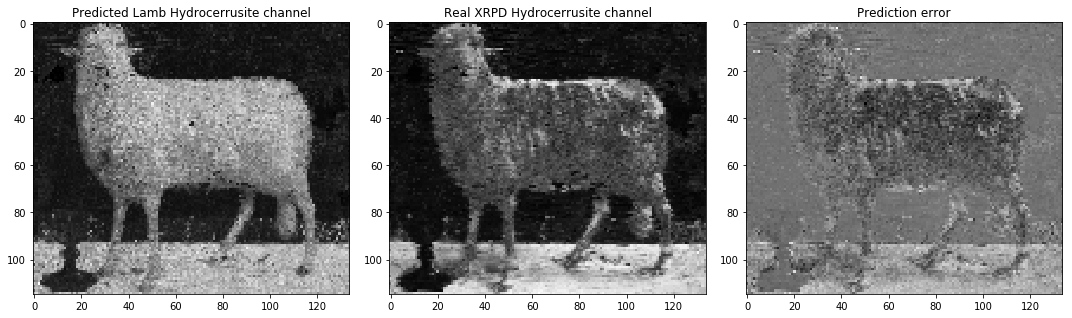

In [103]:
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.set_title("Predicted Lamb Hydrocerrusite channel")
ax.imshow(approx[:,:,0], cmap="gray")
ax = plt.subplot(1,3,2)
ax.set_title("Real XRPD Hydrocerrusite channel")
ax.imshow(pd_norm[:115,:,1], cmap="gray")
ax = plt.subplot(1,3,3)
ax.set_title("Prediction error")
ax.imshow(gain[:,:,0], cmap="gray")
plt.tight_layout()
plt.show()

### Training on median filtered dataset
Section below is an attempt to use data without noise for trainint. This was not used in real processing. Therefore this section is commented out.

In [104]:
# f_med = np.zeros(f_norm.shape)
# for dim in range(f_med.shape[2]):
#     f_med[:,:,dim] = sig.medfilt(f_norm[:,:,dim], kernel_size=5)

In [105]:
# pd_med = np.zeros(pd_norm.shape)
# for dim in range(pd_med.shape[2]):
#     pd_med[:,:,dim] = sig.medfilt(pd_norm[:,:,dim], kernel_size=7)

In [106]:
# [gain, approx, net] = ig(f_med[:115,:,[9, 10]], pd_med[:115,:,[1,3,5]], layers=[100,100,100])

In [107]:
# plt.figure(figsize=(15,5))
# ax = plt.subplot(1,3,1)
# ax.set_title("Predicted Lamb Hydrocerrusite channel (median filter used before training)")
# ax.imshow(approx[:,:,0], cmap="gray")
# ax = plt.subplot(1,3,2)
# ax.set_title("Real XRPD Hydrocerrusite channel median filtered")
# ax.imshow(pd_med[:115,:,1], cmap="gray")
# ax = plt.subplot(1,3,3)
# ax.set_title("Prediction error")
# ax.imshow(gain[:,:,0], cmap="gray")
# plt.show()

In [108]:
# pd_predict = diff.predict(f_norm[:115,:,[9,10]].reshape((115*134,2))).reshape(115,134,3)

In [109]:
# plt.figure(figsize=(15,5))
# ax = plt.subplot(1,3,1)
# ax.imshow(pd_predict[:,:,0], cmap="gray")
# ax = plt.subplot(1,3,2)
# ax.imshow(pd_norm[:115,:,1], cmap="gray")
# ax = plt.subplot(1,3,3)
# ax.imshow(pd_predict[:,:,0]-pd_norm[:115,:,1], cmap="gray")
# plt.show()

In [110]:
# # Normalized XRPD - HC, C, LT
# plt.figure(figsize=(15,10))
# ax = plt.subplot(2,3,1)
# ax.imshow(pd_norm[:,:,1], cmap="gray")
# ax = plt.subplot(2,3,2)
# ax.imshow(pd_norm[:,:,3], cmap="gray")
# ax = plt.subplot(2,3,3)
# ax.imshow(pd_norm[:,:,5], cmap="gray")
# # Median filtered (the same)
# ax = plt.subplot(2,3,4)
# ax.imshow(pd_med[:,:,1], cmap="gray")
# ax = plt.subplot(2,3,5)
# ax.imshow(pd_med[:,:,3], cmap="gray")
# ax = plt.subplot(2,3,6)
# ax.imshow(pd_med[:,:,5], cmap="gray")
# plt.show()

In [111]:
# # Normalized XRF - PbL, PbM
# plt.figure(figsize=(15,10))
# ax = plt.subplot(2,3,1)
# ax.imshow(f_norm[:115,:,9], cmap="gray")
# ax = plt.subplot(2,3,2)
# ax.imshow(f_norm[:115,:,10], cmap="gray")
# ax = plt.subplot(2,3,4)
# ax.imshow(f_med[:115,:,9], cmap="gray")
# ax = plt.subplot(2,3,5)
# ax.imshow(f_med[:115,:,10], cmap="gray")
# plt.show()

## Linear modelling
In the section we tried to simmulate XRPD as a linear combination of PbL and PbM. Comparison of ANN and linalg approach is included

In [112]:
[coef, residua, _, _] = np.linalg.lstsq(pd_norm[:115, :, 1].reshape((115*134,1)), 
                                        f_norm[:115, :, [11,19,24]].reshape((115*134, 3)),rcond=None)

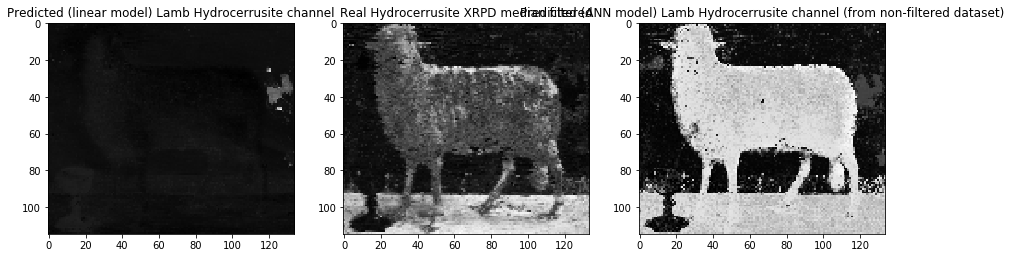

In [113]:
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.set_title("Predicted (linear model) Lamb Hydrocerrusite channel")
ax.imshow((f_norm[:115, :, [9]] * coef[0][0] + f_norm[:115, :, [10]] * coef[0][1]).reshape(115,134), cmap="gray")
ax = plt.subplot(1,3,2)
ax.set_title("Real Hydrocerrusite XRPD median filtered")
ax.imshow(pd_norm[:115, :, 1], cmap="gray")
ax = plt.subplot(1,3,3)
ax.set_title("Predicted (ANN model) Lamb Hydrocerrusite channel (from non-filtered dataset)")
ax.imshow(approx[:,:,1], cmap="gray")
plt.show()

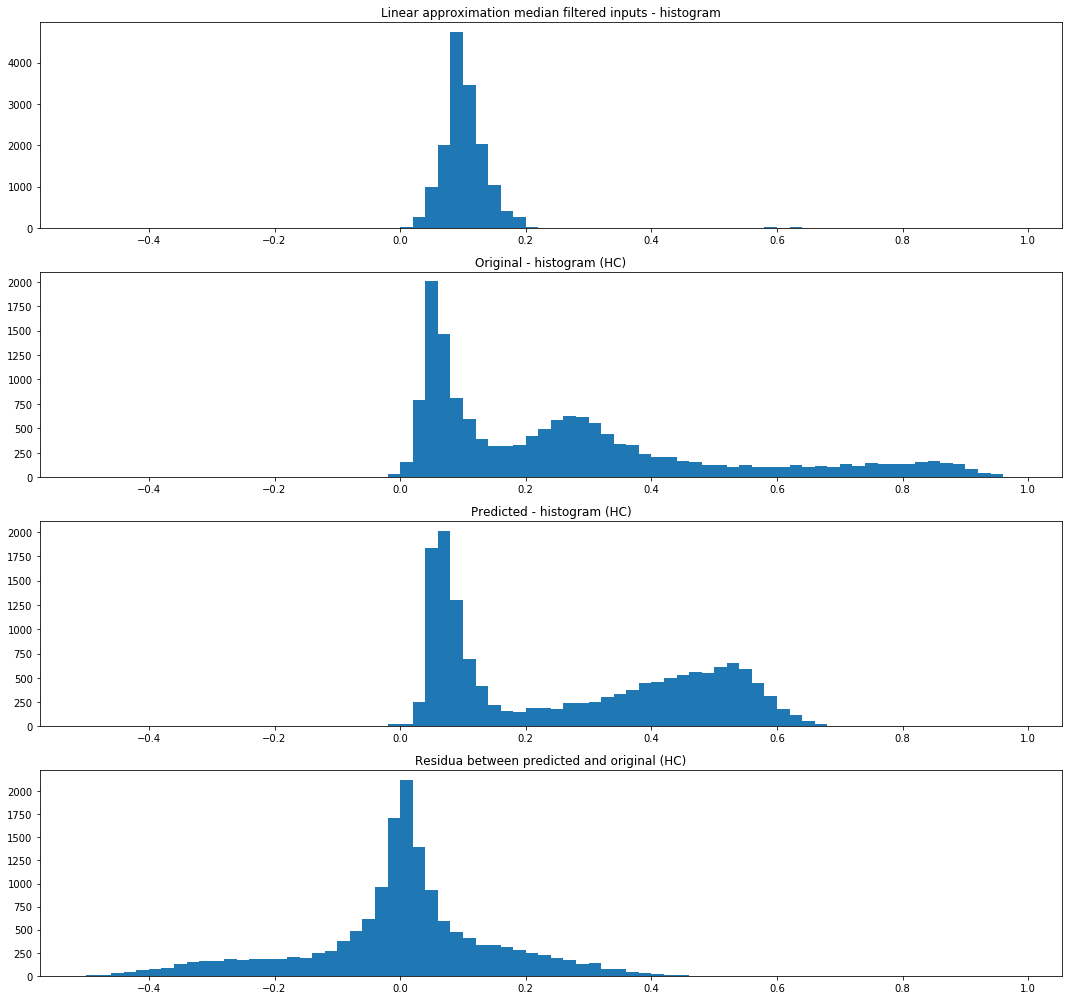

In [114]:
plt.figure(figsize=(15,14))
bins = np.arange(-0.5,1,0.02)
ax = plt.subplot(4,1,1)
ax.set_title("Linear approximation median filtered inputs - histogram")
ax.hist((f_norm[:115, :, [9]] * coef[0][0] + f_norm[:115, :, [10]] * coef[0][1]).reshape(115*134),  bins=bins)
ax = plt.subplot(4,1,2)
ax.set_title("Original - histogram (HC)")
ax.hist(pd_norm[:115, :, 1].reshape(115*134), bins=bins)
ax = plt.subplot(4,1,3)
ax.set_title("Predicted - histogram (HC)")
ax.hist(approx[:,:,0].reshape(115*134), bins=bins)
ax = plt.subplot(4,1,4)
ax.set_title("Residua between predicted and original (HC)")
ax.hist((approx[:,:,0]-pd_norm[:115,:,1]).reshape(115*134), bins=bins)
plt.tight_layout()
plt.show()

In [100]:
# Correlation between approaches. We would like to have higher numbers for ANN approach (approx) 
# compared to linear model:
np.corrcoef(np.moveaxis(
            np.concatenate([f_norm[:115, :, 9].reshape((115*134,1)),
                            f_norm[:115, :, 10].reshape((115*134,1)),
                            pd_norm[:115, :, 1].reshape((115*134,1)),
                            (f_norm[:115, :, [9]] * coef[0][0] + f_norm[:115, :, [10]] * coef[0][1]).reshape((115*134,1)),
                            approx[:,:,0].reshape((115*134,1))
                           ], axis=1),
    0, 1
))

array([[ 1.        ,  0.01449871, -0.22037551,  0.5468195 , -0.24802563],
       [ 0.01449871,  1.        , -0.09547302,  0.84509069, -0.11763636],
       [-0.22037551, -0.09547302,  1.        , -0.19777343,  0.79074617],
       [ 0.5468195 ,  0.84509069, -0.19777343,  1.        , -0.23111559],
       [-0.24802563, -0.11763636,  0.79074617, -0.23111559,  1.        ]])

# Registration matrix
- Matrix was produced in Slicer by @Michal Bartoš
- Here it is used for inverting residua to upscaled space. 
- Our approximation is then corrected by this upscaled residua.

In [29]:
# XRF to XRPD transformation matrix
Tij = [[0.1665, -3.8000e-05, -17.4220],[-4.8909e-04, 0.1787, -63.3877],[0,0,1]]

In [30]:
# XRPD to XRF transformation matrix
Tcv2 = np.float32(np.linalg.inv(Tij)[:2,:])

In [31]:
# XRF original data
pbxrf=np.zeros((1000,1000,2))
pbxrf[:,:,0] = cv2.imread('/Users/gimli/Qsync/datasets/Gent-Altairpiece/lamb/xrf/PbL.png')[:,:,0]
pbxrf[:,:,1] = cv2.imread('/Users/gimli/Qsync/datasets/Gent-Altairpiece/lamb/xrf/PbM.png')[:,:,0]

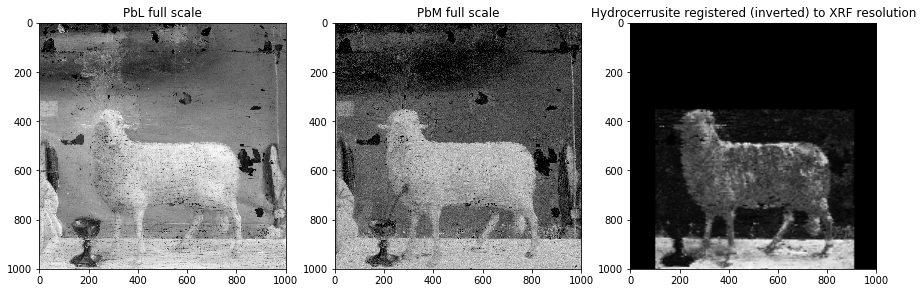

In [32]:
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.set_title("PbL full scale")
ax.imshow(pbxrf[:,:,0], cmap="gray")
ax = plt.subplot(1,3,2)
ax.set_title("PbM full scale")
ax.imshow(pbxrf[:,:,1], cmap="gray")
ax = plt.subplot(1,3,3)
ax.set_title("Hydrocerrusite registered (inverted) to XRF resolution")
ax.imshow(cv2.warpAffine(xrpd[:,:,1], Tcv2, (1000,1000)), cmap="gray")
plt.show()

## Usage of the model for SR
- trained network is used for producing upscaled version of XRPD
- input data must be normalized into N(0,1)
- output data are modified by adding min and max from original XRPD for correct visualization of relative intensities

In [33]:
pbxrf_norm = np.zeros(pbxrf.shape)

# DATA NORMALIZATION
for dim in range(pbxrf.shape[2]):
    pbxrf_norm[:,:,dim] = (pbxrf[:,:,dim] - np.mean(pbxrf[:,:,dim])) / np.std(pbxrf[:,:,dim])
    
# UPSCALE
pd_up = net.predict(pbxrf_norm.reshape(1000*1000,2)).reshape(1000,1000,3)

# RANGE PERSERVATION
# This way we preserve intensity in images.
# One value on the otherside does not have any statistical relevance (but must be ignored in evaluations).
pd_up[0,0,0] = np.min(pd_norm[:,:,1])
pd_up[-1,-1,0] = np.max(pd_norm[:,:,1])

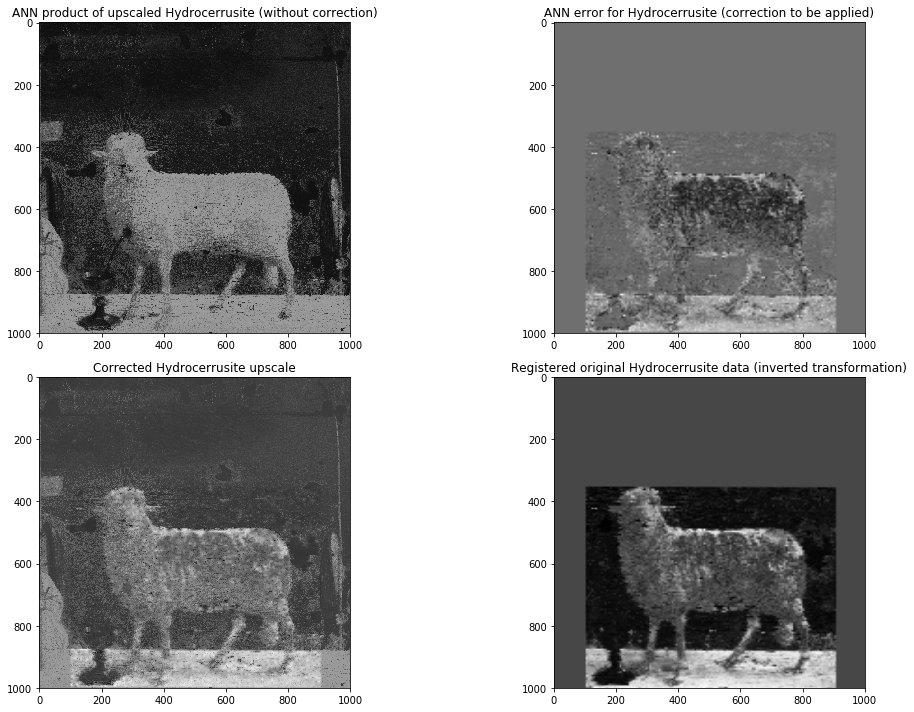

In [34]:
plt.figure(figsize=(15,10))
ax = plt.subplot(2,2,1)
ax.set_title("ANN product of upscaled Hydrocerrusite (without correction)")
ax.imshow(pd_up[:,:,0], cmap="gray")
ax = plt.subplot(2,2,2)
ax.set_title("ANN error for Hydrocerrusite (correction to be applied)")
ax.imshow(cv2.warpAffine(gain[:,:,0], Tcv2, (1000,1000)), cmap="gray")
ax = plt.subplot(2,2,3)
ax.set_title("Corrected Hydrocerrusite upscale")
ax.imshow(pd_up[:,:,0] + cv2.warpAffine(gain[:,:,0], Tcv2, (1000,1000)), cmap="gray")
ax = plt.subplot(2,2,4)
ax.set_title("Registered original Hydrocerrusite data (inverted transformation)")
ax.imshow(cv2.warpAffine(pd_norm[:,:,1], Tcv2, (1000,1000)), cmap="gray")
plt.tight_layout()
plt.show()

## Comparison of value distributions

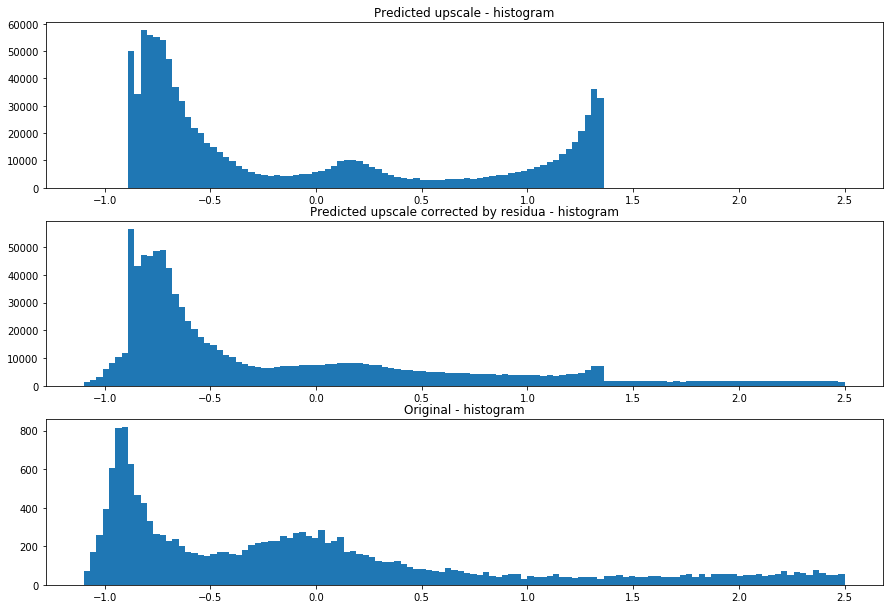

In [35]:
plt.figure(figsize=(15,14))
ax = plt.subplot(4,1,1)
ax.set_title("Predicted upscale - histogram")
ax.hist(pd_up[:,:,0].reshape(1000*1000,1), bins=np.arange(-1.1,2.5,0.03))
ax = plt.subplot(4,1,2)
ax.set_title("Predicted upscale corrected by residua - histogram")
ax.hist((pd_up[:,:,0] + cv2.warpAffine(gain[:,:,0], Tcv2, (1000,1000))).reshape(1000*1000,1), bins=np.arange(-1.1,2.5,0.03))
ax = plt.subplot(4,1,3)
ax.set_title("Original - histogram")
ax.hist(pd_norm[:,:,1].reshape(pd_norm.shape[0]*pd_norm.shape[1],1), bins=np.arange(-1.1,2.5,0.03))
plt.show()

## Production of reports (images)
In the section below is necessary to setup properly which channel will be exported

In [36]:
xrpd_dim = 5 # one of [1, 3, 5]
pd_up_dim = 2 # one of [0, 1, 2]
filename_base = "lty" # one of ["hc", "c", "lty"] hydrocerrusite, cerrusite, lead-tin yellow

In [37]:
pd_up_denorm = (pd_up[:,:,pd_up_dim] + cv2.warpAffine(gain[:,:,2], Tcv2, (1000,1000))) \
                * pd_std[xrpd_dim] + pd_avg[xrpd_dim]
pd_up_denorm[0,0] = np.min(xrpd[:,:,xrpd_dim])
pd_up_denorm [-1,-1] = np.max(xrpd[:,:,xrpd_dim])

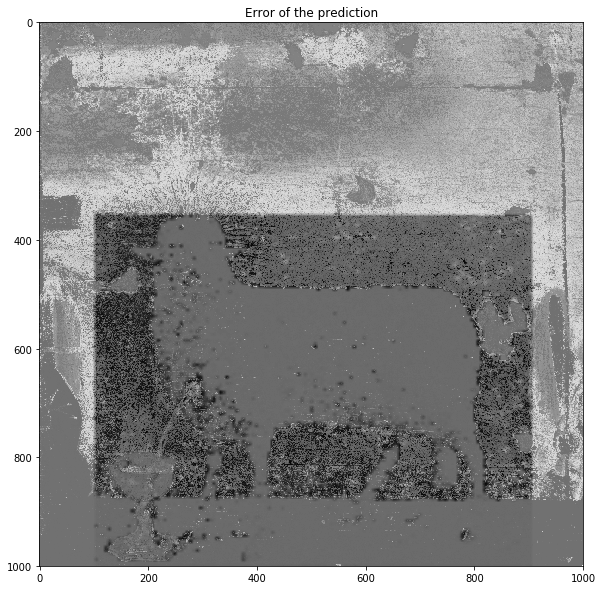

In [38]:
plt.figure(figsize=(10,10))
plt.imshow(
    pd_up_denorm - cv2.warpAffine(xrpd[:,:,xrpd_dim], Tcv2, (1000,1000)), 
    cmap="gray")
plt.title("Error of the prediction")
plt.show()

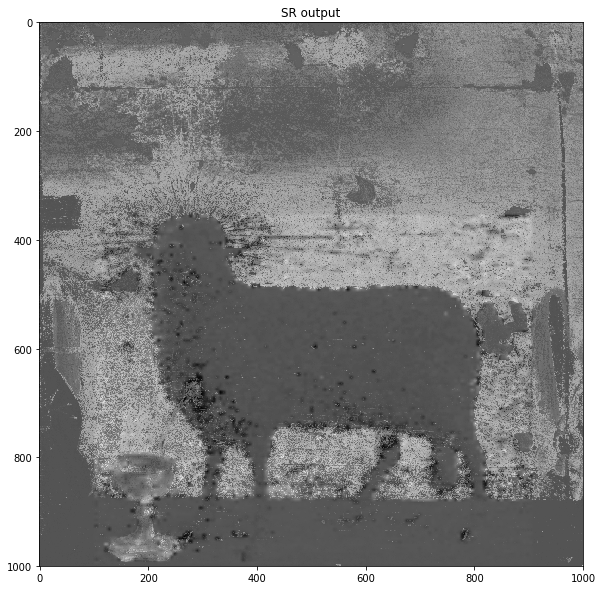

In [39]:
plt.figure(figsize=(10,10))
plt.imshow(pd_up_denorm, cmap="gray")
plt.title("SR output")
plt.show()

### Scale data to preserve original distribution

In [40]:
c_orig = cv2.warpAffine(xrpd[:,:,xrpd_dim], Tcv2, (1000,1000))
c_write = (c_orig - np.min(c_orig)) / (np.max(c_orig) - np.min(c_orig)) * 255

cv2.imwrite(f'/Users/gimli/Qsync/datasets/Gent-Altairpiece/{filename_base}.png', c_write)

True

In [41]:
cv2.imwrite(f'/Users/gimli/Qsync/datasets/Gent-Altairpiece/{filename_base}up.png', 
            (pd_up_denorm - np.min(c_orig)) / (np.max(c_orig) - np.min(c_orig)) * 255)

True

## Testing of ANN limitations
- it seems that there is maximum and minimum of y_exp limitted??

In [42]:
ins = np.random.random_sample((100,100,1))
ous = ins * 1000

[g, a, n] = ig(ins,ous)

Selecting 25000 samples randomly for use by algorithm.
Adding input layer, width = 1
Adding dense layer, width = 25
Adding dense layer, width = 25
Adding dense layer, width = 1
Compiling model took 0.1887's.
Train on 8000 samples, validate on 2000 samples
Epoch 1/300
8000/8000 [==============================] - 1s 103us/sample - loss: 325161.0241 - mean_squared_error: 325161.0312 - val_loss: 325091.9280 - val_mean_squared_error: 325091.9062
Epoch 2/300
8000/8000 [==============================] - 0s 54us/sample - loss: 318549.4361 - mean_squared_error: 318549.4375 - val_loss: 319520.7618 - val_mean_squared_error: 319520.7812
Epoch 3/300
8000/8000 [==============================] - 1s 68us/sample - loss: 313548.2549 - mean_squared_error: 313548.1875 - val_loss: 314714.5285 - val_mean_squared_error: 314714.5000
Epoch 4/300
8000/8000 [==============================] - 0s 53us/sample - loss: 308595.9874 - mean_squared_error: 308595.9688 - val_loss: 309478.9718 - val_mean_squared_error: 309

8000/8000 [==============================] - 1s 93us/sample - loss: 152486.3089 - mean_squared_error: 152486.2969 - val_loss: 151014.7745 - val_mean_squared_error: 151014.7500
Epoch 44/300
8000/8000 [==============================] - 0s 54us/sample - loss: 149258.5333 - mean_squared_error: 149258.5469 - val_loss: 147897.2674 - val_mean_squared_error: 147897.2969
Epoch 45/300
8000/8000 [==============================] - 0s 53us/sample - loss: 146348.8007 - mean_squared_error: 146348.8281 - val_loss: 144918.3070 - val_mean_squared_error: 144918.2812
Epoch 46/300
8000/8000 [==============================] - 0s 53us/sample - loss: 143098.2238 - mean_squared_error: 143098.2188 - val_loss: 141513.4741 - val_mean_squared_error: 141513.4688
Epoch 47/300
8000/8000 [==============================] - 0s 54us/sample - loss: 140152.8965 - mean_squared_error: 140152.8750 - val_loss: 138600.6871 - val_mean_squared_error: 138600.7031
Epoch 48/300
8000/8000 [==============================] - 0s 55us/sa

Epoch 87/300
8000/8000 [==============================] - 1s 79us/sample - loss: 44578.8875 - mean_squared_error: 44578.8906 - val_loss: 43248.4675 - val_mean_squared_error: 43248.4648
Epoch 88/300
8000/8000 [==============================] - 0s 57us/sample - loss: 43145.1090 - mean_squared_error: 43145.1289 - val_loss: 41823.4553 - val_mean_squared_error: 41823.4453
Epoch 89/300
8000/8000 [==============================] - 0s 55us/sample - loss: 41745.0301 - mean_squared_error: 41745.0234 - val_loss: 40428.7038 - val_mean_squared_error: 40428.6953
Epoch 90/300
8000/8000 [==============================] - 1s 79us/sample - loss: 40375.9534 - mean_squared_error: 40375.9531 - val_loss: 39073.2853 - val_mean_squared_error: 39073.2812
Epoch 91/300
8000/8000 [==============================] - 0s 56us/sample - loss: 39039.2404 - mean_squared_error: 39039.2578 - val_loss: 37747.6502 - val_mean_squared_error: 37747.6562
Epoch 92/300
8000/8000 [==============================] - 0s 53us/sample - 

8000/8000 [==============================] - 0s 54us/sample - loss: 178.0457 - mean_squared_error: 178.0457 - val_loss: 147.5751 - val_mean_squared_error: 147.5751
Epoch 177/300
8000/8000 [==============================] - 0s 52us/sample - loss: 157.2393 - mean_squared_error: 157.2393 - val_loss: 130.1753 - val_mean_squared_error: 130.1753
Epoch 178/300
8000/8000 [==============================] - 0s 55us/sample - loss: 138.5680 - mean_squared_error: 138.5680 - val_loss: 114.4304 - val_mean_squared_error: 114.4304
Epoch 179/300
8000/8000 [==============================] - 0s 55us/sample - loss: 121.8469 - mean_squared_error: 121.8469 - val_loss: 100.4869 - val_mean_squared_error: 100.4869
Epoch 180/300
8000/8000 [==============================] - 0s 53us/sample - loss: 106.8908 - mean_squared_error: 106.8908 - val_loss: 87.8423 - val_mean_squared_error: 87.8423
Epoch 181/300
8000/8000 [==============================] - 0s 55us/sample - loss: 93.6408 - mean_squared_error: 93.6408 - val_

8000/8000 [==============================] - 1s 70us/sample - loss: 0.4078 - mean_squared_error: 0.4078 - val_loss: 0.4531 - val_mean_squared_error: 0.4531
Epoch 272/300
8000/8000 [==============================] - 1s 73us/sample - loss: 0.3962 - mean_squared_error: 0.3962 - val_loss: 0.4499 - val_mean_squared_error: 0.4499
Epoch 273/300
8000/8000 [==============================] - 0s 62us/sample - loss: 0.3827 - mean_squared_error: 0.3827 - val_loss: 0.4279 - val_mean_squared_error: 0.4279
Epoch 274/300
8000/8000 [==============================] - 0s 55us/sample - loss: 0.3833 - mean_squared_error: 0.3833 - val_loss: 0.4404 - val_mean_squared_error: 0.4404
Epoch 275/300
8000/8000 [==============================] - 0s 58us/sample - loss: 0.3604 - mean_squared_error: 0.3604 - val_loss: 0.4077 - val_mean_squared_error: 0.4077
Epoch 276/300
8000/8000 [==============================] - 0s 57us/sample - loss: 0.3569 - mean_squared_error: 0.3569 - val_loss: 0.4091 - val_mean_squared_error: 0

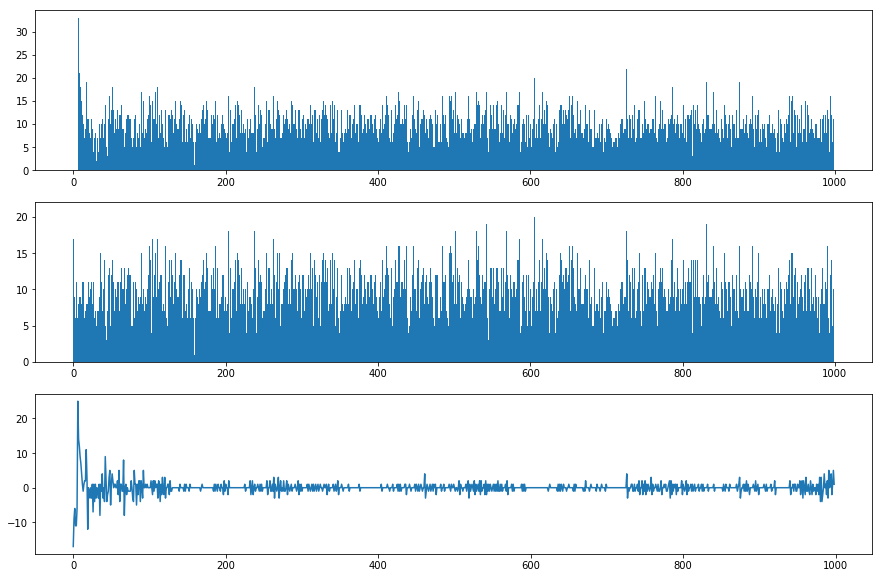

In [43]:
plt.figure(figsize=(15,10))
ax = plt.subplot(3,1,1)
h1 = ax.hist(a.reshape(10000,1), bins=np.arange(0,1000,1))
ax = plt.subplot(3,1,2)
h2 = ax.hist(ins.reshape(10000,1)*1000, bins=np.arange(0,1000,1))
ax = plt.subplot(3,1,3)
ax.plot((h1[0]-h2[0]).tolist())
plt.show()

In [44]:
n.layers[-1].get_weights()

[array([[ 42.072884],
        [ 41.70694 ],
        [ 42.0019  ],
        [ 42.060677],
        [ 41.406475],
        [ 42.366722],
        [ 42.118546],
        [-28.234118],
        [ 33.818333],
        [ 41.803047],
        [ 40.12802 ],
        [ 41.90331 ],
        [ 42.080486],
        [ 42.12281 ],
        [ 41.957043],
        [ 41.00413 ],
        [ 41.56855 ],
        [ 42.266537],
        [ 42.33575 ],
        [ 42.10991 ],
        [ 42.00413 ],
        [ 39.590546],
        [ 42.427578],
        [ 33.893803],
        [ 41.807858]], dtype=float32), array([31.314613], dtype=float32)]